In [239]:
import os
import numpy as np
import pandas as pd
from glob import glob

COMPETITION_NAME = 'cap-4611-spring-21-practice-assignment'
DATA_DIR = './data'
RANDOM_STATE = 1337

# create data directory if not exists
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

!kaggle competitions download -c '{COMPETITION_NAME}' -p '{DATA_DIR}/'
!unzip -nq '{DATA_DIR}/{COMPETITION_NAME}' -d '{DATA_DIR}/'
!rm '{DATA_DIR}/{COMPETITION_NAME}.zip'

  0%|                                               | 0.00/1.61k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 1.61k/1.61k [00:00<00:00, 1.67MB/s]


In [240]:
paths = dict()

for path in glob(f'{DATA_DIR}/*'):
    filename = os.path.basename(path)
    fn = os.path.splitext(filename)[0]
    paths[fn] = path

paths

{'test': './data/test.csv',
 'train': './data/train.csv',
 'submission-kde-1': './data/submission-kde-1.csv',
 'sample_submission': './data/sample_submission.csv'}

## Import CSV's
First column is the index, so we set it by appending `index_col=0`.

In [241]:
train_df = pd.read_csv(paths['train'], index_col=0)
test_df = pd.read_csv(paths['test'], index_col=0)

df = test_df.append(train_df)

In [255]:
train_values = train_df.values
test_values = test_df.values

for tv in train_values:
    for vv in test_values:
        if (tv[:-1] == vv).all():
            print(tv)

[4.9 3.1 1.5 0.1 0. ]
[4.9 3.1 1.5 0.1 0. ]


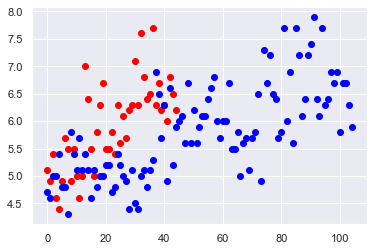

In [266]:
x_test = range(len(test_df))
y_test = test_df.loc[:,test_df.columns[0]]
x_train = range(len(train_df))
y_train = train_df.loc[:,train_df.columns[0]]

plt.scatter(x_test, y_test, color='red')
plt.scatter(x_train, y_train, color='blue')

plt.show()

In [233]:
df.describe()

,x1,x2,x3,x4,Species
count,150.000000,150.000000,150.000000,150.000000,105.000000
mean,5.843333,3.054000,3.758667,1.198667,0.971429
std,0.828066,0.433594,1.764420,0.763161,0.825753
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [234]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

Scaler = StandardScaler()
Normal = Normalizer()

X = df.loc[:,df.columns.difference(['Species'])]

Scaler.fit(X)
Normal.fit(X)
X_scaled = Scaler.transform(X)
X_normal = Normal.transform(X)

train_df = pd.DataFrame(X_normal[:len(train_df)], columns=X.columns, index=train_df.index)
train_df['Species'] = train_df.loc[:,'Species']
train_df.index.name = 'Id'

# y = train_df.loc[:,'Species']

X_train, X_test, y_train, y_test = train_test_split(X_normal, y, test_size=.2, random_state=RANDOM_STATE, shuffle=True)

KeyError: 'Species'

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
sns.set()

%matplotlib inline

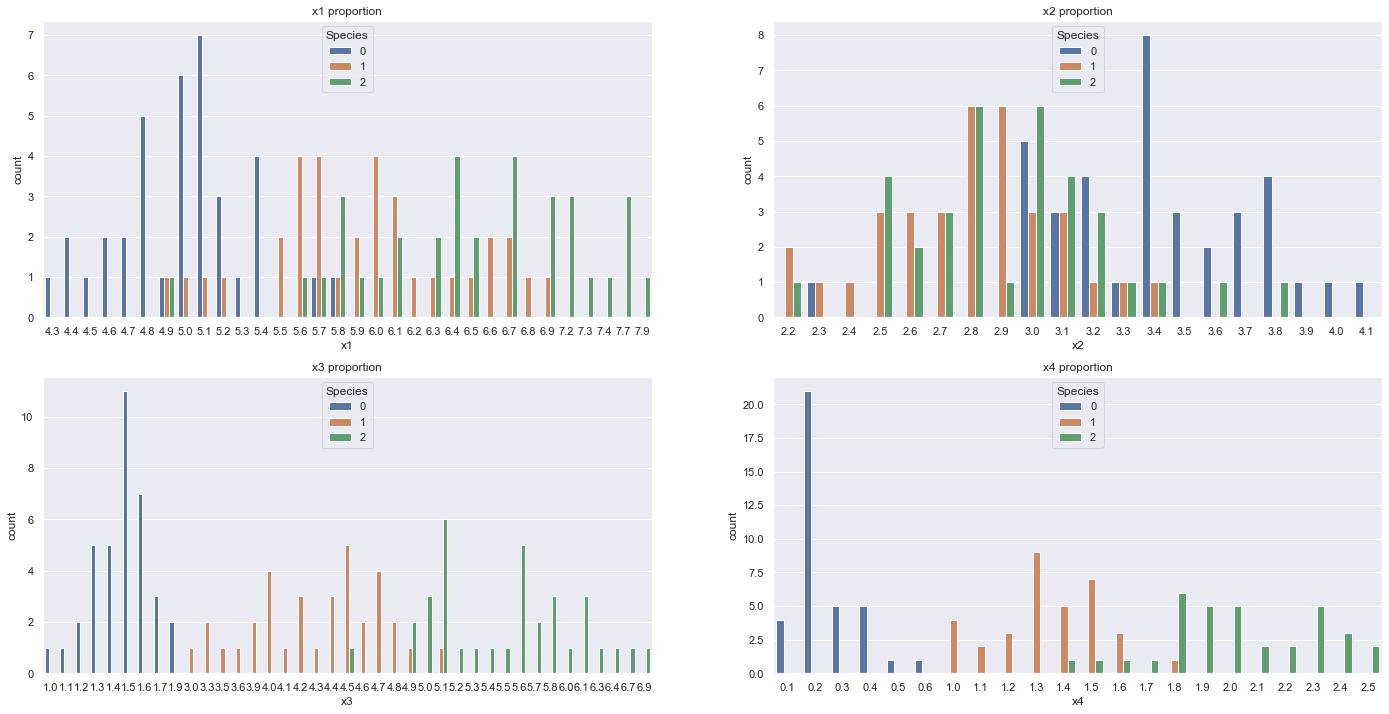

In [203]:
shape = (2,2)
fig = plt.figure(figsize=(24,12))

for i, feature in enumerate(train_df.columns.difference(['Species'])):
    ax = fig.add_subplot(*shape,i+1)
    ax.title.set_text('{} proportion'.format(feature))
    sns.countplot(data=train_df, x=feature, hue='Species', ax=ax)

plt.show()

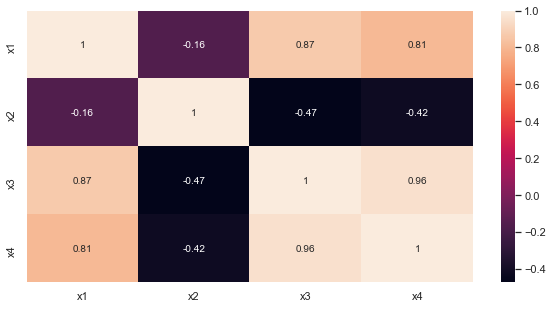

In [204]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(train_df.loc[:,train_df.columns.difference(['Species'])].corr(), annot=True, ax=ax)
plt.show()

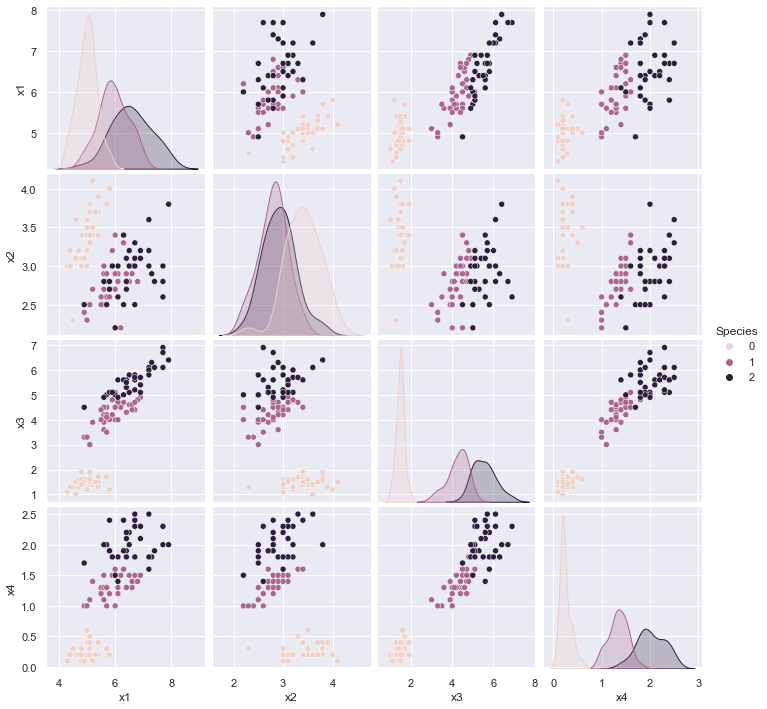

In [205]:
g = sns.pairplot(train_df, hue='Species')
plt.show()

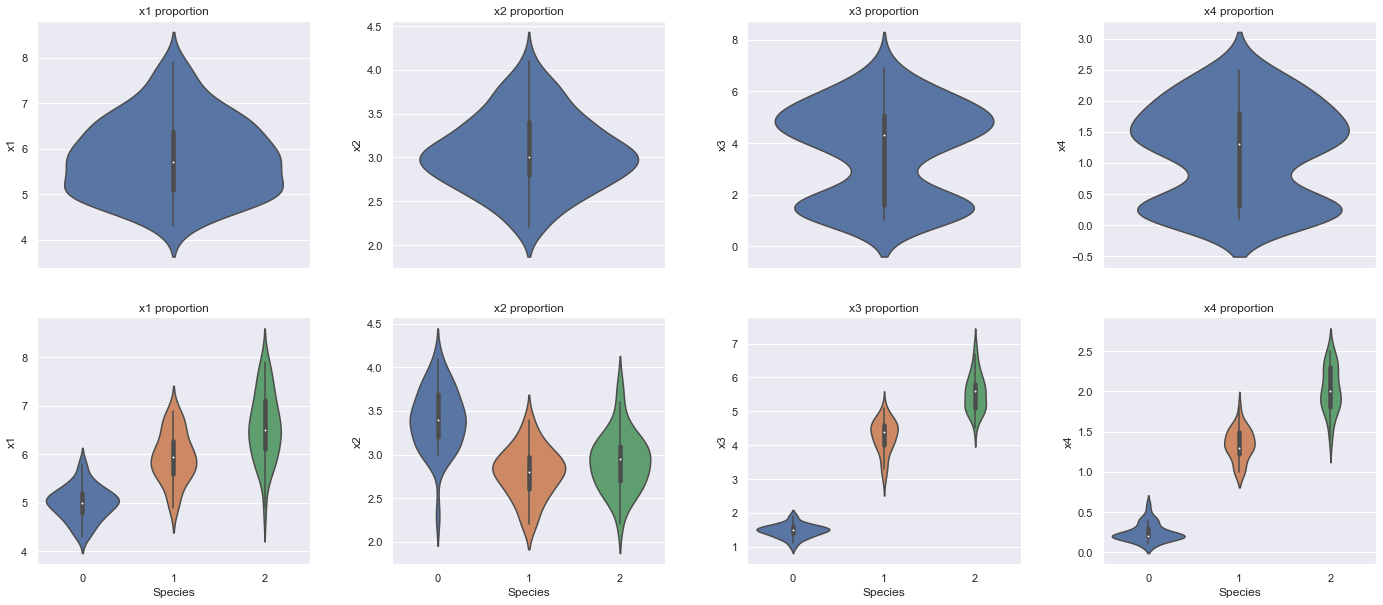

In [206]:
shape = (2,4)
fig = plt.figure(figsize=(24,10))

for i, feature in enumerate(train_df.columns.difference(['Species'])):
    ax = fig.add_subplot(*shape,i+1)
    ax.title.set_text('{} proportion'.format(feature))
    sns.violinplot(data=train_df, y=feature, ax=ax)

for i, feature in enumerate(train_df.columns.difference(['Species'])):
    ax = fig.add_subplot(*shape,i+1+4)
    ax.title.set_text('{} proportion'.format(feature))
    sns.violinplot(data=train_df, x='Species', y=feature, ax=ax)
    
plt.subplots_adjust(wspace=.3)
plt.show()

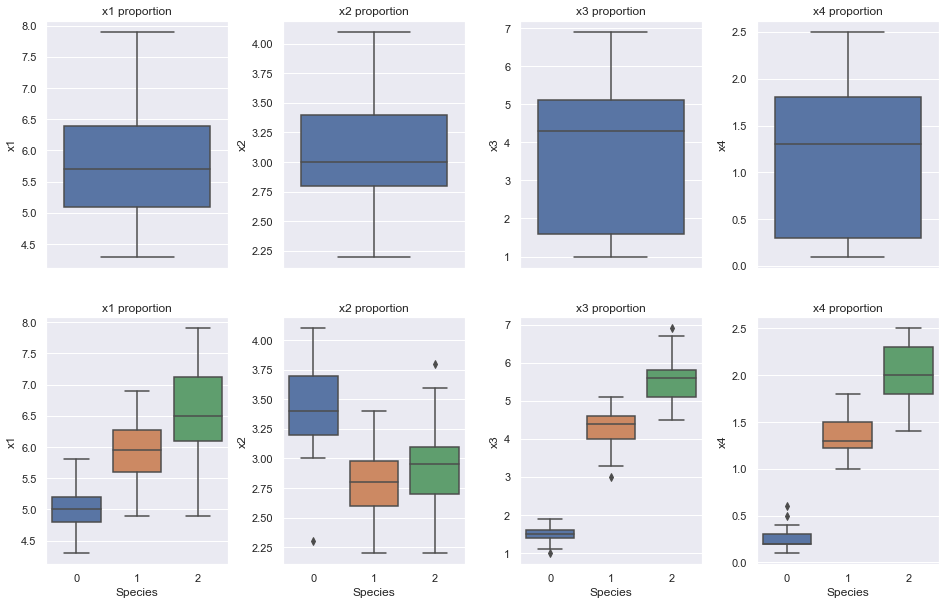

In [220]:
shape = (2,4)
fig = plt.figure(figsize=(16,10))

for i, feature in enumerate(train_df.columns.difference(['Species'])):
    ax = fig.add_subplot(*shape,i+1)
    ax.title.set_text('{} proportion'.format(feature))
    sns.boxplot(data=train_df, y=feature, ax=ax)

for i, feature in enumerate(train_df.columns.difference(['Species'])):
    ax = fig.add_subplot(*shape,i+1+4)
    ax.title.set_text('{} proportion'.format(feature))
    sns.boxplot(data=train_df, x='Species', y=feature, ax=ax)
    
plt.subplots_adjust(wspace=.3)
plt.show()

In [173]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

param_grid = dict(
    kernel=['gaussian','tophat','linear','epanechnikov','cosine','exponential'],
    bandwidth=np.linspace(-4, 4, 100),
    algorithm=['kd_tree','ball_tree'],
    leaf_size=np.linspace(1,300,30, dtype=int),
    breadth_first=[False, True]
)
grid = GridSearchCV(KernelDensity(), param_grid=param_grid, verbose=10, n_jobs=-1)
grid.fit(X_train)

Fitting 5 folds for each of 72000 candidates, totalling 360000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0156s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0387s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0420s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0581s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Don

GridSearchCV(estimator=KernelDensity(), n_jobs=-1,
             param_grid={'algorithm': ['kd_tree', 'ball_tree'],
                         'bandwidth': array([-4.        , -3.91919192, -3.83838384, -3.75757576, -3.67676768,
       -3.5959596 , -3.51515152, -3.43434343, -3.35353535, -3.27272727,
       -3.19191919, -3.11111111, -3.03030303, -2.94949495, -2.86868687,
       -2.78787879, -2.70707071, -2.62626263, -2.54545455, -2.46464646,
       -2....
        3.27272727,  3.35353535,  3.43434343,  3.51515152,  3.5959596 ,
        3.67676768,  3.75757576,  3.83838384,  3.91919192,  4.        ]),
                         'breadth_first': [False, True],
                         'kernel': ['gaussian', 'tophat', 'linear',
                                    'epanechnikov', 'cosine', 'exponential'],
                         'leaf_size': array([  1,  11,  21,  31,  42,  52,  62,  73,  83,  93, 104, 114, 124,
       135, 145, 155, 165, 176, 186, 196, 207, 217, 227, 238, 248, 258,
       269, 27

In [174]:
kde_model = grid.best_estimator_
params = kde_model.get_params()
grid.best_estimator_

KernelDensity(algorithm='kd_tree', bandwidth=0.040404040404040664,
              breadth_first=False, leaf_size=1)

In [178]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    '''
    Bayesian generative classification based on KDE
    
    Parameters
    ----------
    kernel : dict
        the dictionary of parameters spread into KernelDensity
    '''

    def __init__(self, params=dict()):
        self.params = params
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(**self.params).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [179]:
kde_classifier = KDEClassifier(params)
kde_classifier.fit(X_train, y_train)

KDEClassifier(params={'algorithm': 'kd_tree', 'atol': 0,
                      'bandwidth': 0.040404040404040664, 'breadth_first': False,
                      'kernel': 'gaussian', 'leaf_size': 1,
                      'metric': 'euclidean', 'metric_params': None, 'rtol': 0})

In [187]:
y_pred = kde_classifier.predict(X_test)
acc = np.mean(y_pred == y_test)
print('Test accuracy: {:.4f}, Test error: {:.4f}'.format(acc, 1-acc))

print('\nClassification report:')
print(classification_report(y_test, y_pred))

# Test accuracy: 0.9524, Test error: 0.0476

# Classification report:
#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00         7
#            1       1.00      0.89      0.94         9
#            2       0.83      1.00      0.91         5

#     accuracy                           0.95        21
#    macro avg       0.94      0.96      0.95        21
# weighted avg       0.96      0.95      0.95        21

Test accuracy: 0.9524, Test error: 0.0476

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.89      0.94         9
           2       0.83      1.00      0.91         5

    accuracy                           0.95        21
   macro avg       0.94      0.96      0.95        21
weighted avg       0.96      0.95      0.95        21



In [208]:
from xgboost import XGBClassifier as XGB

param_grid = {
    'n_estimators': [100, 1000, 2000],
    'learning_rate': [.01, .1, 0.3],
    'max_depth': [1, 3, 6],
    'subsample': [.5, 1], 
    'colsample_bylevel': [.5, 1]
}

xgb_clf = GridSearchCV(XGBC(nthreads=4), param_grid=param_grid, verbose=10, n_jobs=-1)
xgb_clf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed: 

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthreads=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, valida

In [211]:
scores = xgb_clf.cv_results_['mean_test_score']
print('Best params:', xgb_clf.best_params_)
print('Best accuracy:', xgb_clf.best_score_)

Best params: {'colsample_bylevel': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Best accuracy: 0.9639705882352942


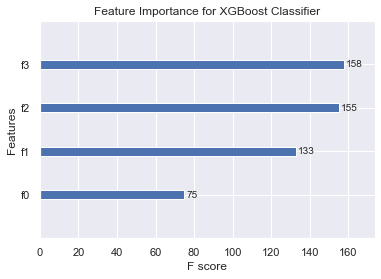

In [212]:
from xgboost import plot_importance

xgb_classifier = xgb_clf.best_estimator_
fig, ax = plt.subplots(figsize=(6,4))
plot_importance(xgb_classifier, ax=ax)
plt.title('Feature Importance for XGBoost Classifier')
plt.show()

In [213]:
y_pred = xgb_classifier.predict(X_test)
acc = np.mean(y_pred == y_test)
print('Test accuracy: {:.4f}, Test error: {:.4f}'.format(acc, 1-acc))

# print('\nClassification report:')
# print(classification_report(y_test, y_pred))

Test accuracy: 0.8571, Test error: 0.1429


In [149]:
y_pred.shape, test_df.index.shape

((21,), (45,))

In [150]:
submission_y_pred = kde_classifier.predict(test_df)
submission_df = pd.DataFrame(dict(Species=submission_y_pred), index=test_df.index)
submission_df.index.name = 'Id'
submission_df.to_csv(f'{DATA_DIR}/submission-kde-1.csv', index=True)

In [151]:
!kaggle competitions submit -c cap-4611-spring-21-practice-assignment -f '{DATA_DIR}/submission-kde-1.csv' -m 'Using KDE Classifier'

100%|████████████████████████████████████████████| 226/226 [00:00<00:00, 297B/s]
Successfully submitted to CAP 4611 - Spring 21 - Practice Assignment

In [28]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)
lin_reg.coef_, lin_reg.intercept_

(array([-0.18595446, -0.00945094,  0.30916026,  0.51818327]),
 0.34553766151243615)

In [29]:
lin_reg.score(X_test, y_test)

0.9079535699045673

In [50]:
from sklearn.linear_model import LinearRegression as LNR
from sklearn.linear_model import Ridge as RGR
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc, classification_report
from sklearn.model_selection import GridSearchCV

def get_model(model, parameters=dict()):
    m = eval(model)(**parameters)
    m.fit(X_train, y_train)
    
    print('-'*5, model, '-'*5)
    print(m.score(X_test, y_test))
    
    return m

def report(clf, X=None, y=None, only_best=True):
    scores = clf.cv_results_['mean_test_score']

    if not only_best:
        for score, p in zip(scores, clf.cv_results_['params']):
            print('Accuracy: %0.4f | %r' % (score, p))

    print('Best params:', clf.best_params_)
    print('Best accuracy:', clf.best_score_)
    print('\nClassification report:')
    y_pred = clf.predict(X)
    print(classification_report(y, y_pred))

In [51]:
lnr_model = get_model('LNR')
lnr_model = get_model('RGR', dict(alpha=.2))
lgr_model = get_model('LGR')

----- LNR -----
0.9079535699045673
----- RGR -----
0.9081644547430874
----- LGR -----
0.9523809523809523


In [52]:
pd.read_csv(paths['sample_submission'], index_col=0).head()

,Species
Id,
0,2
1,0
2,1
3,2
4,1


In [53]:
# submission_y_pred = lgr_model.predict(test_df)
# submission_df = pd.DataFrame(dict(Species=submission_y_pred), index=test_df.index)
# submission_df.index.name = 'Id'
# submission_df.to_csv('submission.csv', index=True)